In [1]:
pip install ehtim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.8/159.8 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 445.0/445.0 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.9/466.9 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.5/234.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 7.2 MB/s eta 0:00:00
  Created wheel for paramsurvey: filename=paramsurvey-0.4.21-py3-none-any.whl size=36646 sha256=aae1f0409060997a82bebc8a3c4db22b7a06c96772ef26ca6f5d4e25c54b014a
  Stored in directory: /root/.cache/pip/wheels/94/4b/40/1b40fe793dd35ee7679b1d4349a1739916ced1d2c87c2b88c4
  Created wheel for pandas-appender: filename=pandas_appender-0.9.9-py3-none-any.whl size

In [2]:
pip install latex

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for latex: filename=latex-0.7.0-py3-none-any.whl size=7588 sha256=ba76a4674cb5cc36c95e20caf20f82f094b60de4b95ec3cd98d9feb6b96713ef
  Stored in directory: /root/.cache/pip/wheels/7e/02/25/c00dfc203e8ba53dfc2e4e97d40e537263d6e03606681f3872
  Created wheel for data: filename=data-0.4-py3-none-any.whl size=7227 sha256=6b5148912c08af2420fce74f9876a5db23cf5b19256cc1571b8e3d69f4116fd8
  Stored in directory: /root/.cache/pip/wheels/d0/e8/fa/e253c256048ea58d99a8abb5e751abb6a838af6f12887b5418
  Created wheel for shutilwhich: filename=shutilwhich-1.1.0-py3-none-any.whl size=2766 sha256=97cf00c079fdf2adfc025b32d4a5315749a3ceb6db5806a59e7dc7046caaf3e3
  Stored in directory: /root/.cache/pip/wheels/75/1f/1c/0ecab7ceabad0b8e018891505911e82a6f358a0291e7681bae
  Created wheel for tempdir: filename=tempdir-0.7.1-py3-none-any.w

Welcome to eht-imaging! v 1.2.10 

Loading uvfits:  /kaggle/input/uvfits/L2V1_M87_2018_111_b1_casa_netcal_10s_StokesI.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!


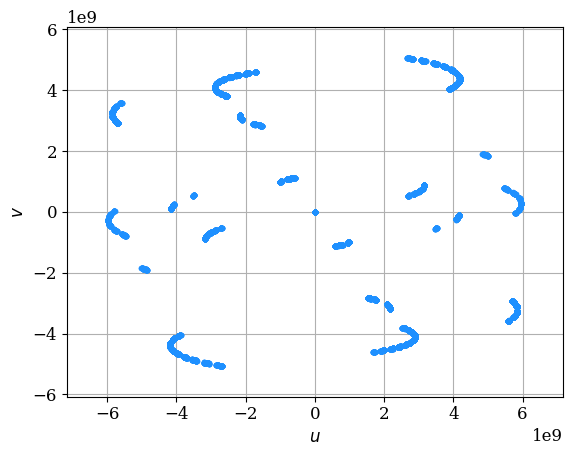

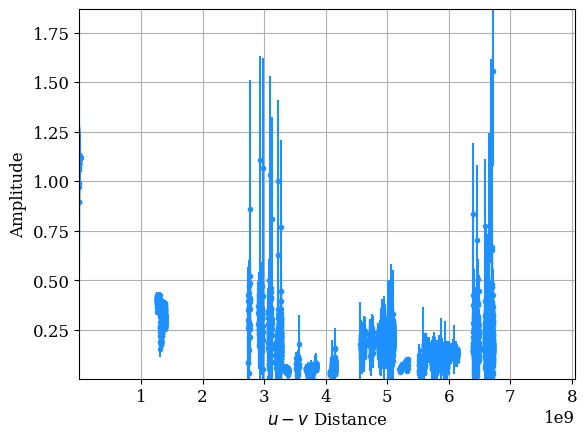

<Axes: xlabel='$u-v$ Distance', ylabel='Amplitude'>

In [3]:
import ehtim as eh
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# Load the data
inobs = '/kaggle/input/uvfits/L2V1_M87_2018_111_b1_casa_netcal_10s_StokesI.uvfits'
obs   = eh.obsdata.load_uvfits(inobs)

# Inspect the data
obs.plotall('u', 'v', conj=True) 
obs.plotall('uvdist', 'amp')


In [4]:
# Do some time averaging
obs.add_scans()
obs = obs.avg_coherent(0., scan_avg=True)

# Zero baseline flux (as measured by ALMA-APEX)
zbl = np.median(obs.unpack_bl('AA','AX','amp')['amp'])

# Array nominal resolution
res = obs.res()

# Non-closing error budget (1%)
obs = obs.add_fractional_noise(0.01)

# Make a copy of the initial data
obs_init = obs.copy()



/usr/local/lib/python3.10/dist-packages/ehtim/statistics/dataframes.py:198: FutureWarning: The provided callable <function min at 0x7ae0d8233f40> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  vis_avg = vis.groupby(grouping).agg(aggregated).reset_index()
/usr/local/lib/python3.10/dist-packages/ehtim/statistics/dataframes.py:198: FutureWarning: The provided callable <function min at 0x7ae0d8233f40> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  vis_avg = vis.groupby(grouping).agg(aggregated).reset_index()
/usr/local/lib/python3.10/dist-packages/ehtim/statistics/dataframes.py:198: FutureWarning: The provided callable <function mean at 0x7ae0d8264790> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable w

In [5]:
# Image parameters
npix       = 100
fov        = 700*eh.RADPERUAS
prior_fwhm = 100*eh.RADPERUAS
shift      = 170*eh.RADPERUAS

# Gaussian prior image
gaussprior = eh.image.make_square(obs, npix, fov)
gaussprior = gaussprior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0,
                                    	 shift, -shift))

# Large disk to capture extended emission
gaussprior = gaussprior.add_tophat(zbl*0.1, fov/2).blur_circ(res)

# To avoid gradient singularities in the first step,
# add an additional small Gaussian
gaussprior = gaussprior.add_gauss(zbl*1e-3, (prior_fwhm, 
                                             prior_fwhm, 0, 0, 0))



In [6]:
# Data terms and regularizers
data_term = {'amp': 1, 'cphase': 1, 'logcamp': 1}
reg_term  = {'simple': 0, 'tv': 1, 'tv2': 0, 'l1': 1}

# Initialize imaging with a Gaussian image
imgr = eh.imager.Imager(obs, gaussprior, prior_im=gaussprior,
                    	  flux=zbl, data_term=data_term, maxit=350,
                    	  norm_reg=True, reg_term=reg_term, ttype='direct',
                    	  stop=1e-6)
# Imaging
imgr.make_image_I(show_updates=False)
for repeat in range(4):
    	imgr.init_next = imgr.out_last().blur_circ(res)
    	imgr.make_image_I(show_updates=False)

# Self-calibrate to the previous model
obs_sc = eh.selfcal(obs, imgr.out_last(), method='both', ttype='direct',
                    solution_interval=0.0, processes=0)



Initializing imager data products . . .
Imager run 1 
Imaging . . .
time: 8.687088 s
J: 19.409591
chi2_amp : 14.85 chi2_cphase : 0.85 chi2_logcamp : 1.82 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 2 
Imaging . . .
time: 8.532790 s
J: 16.083992
chi2_amp : 12.32 chi2_cphase : 0.75 chi2_logcamp : 1.63 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 3 
Imaging . . .
time: 8.373769 s
J: 15.485669
chi2_amp : 12.01 chi2_cphase : 0.69 chi2_logcamp : 1.58 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 4 
Imaging . . .
time: 8.679415 s
J: 15.264813
chi2_amp : 11.83 chi2_cphase : 0.62 chi2_logcamp : 1.55 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 5 
Imaging . . .
time: 8.415468 s
J: 14.992902
chi2_amp : 11.52 chi2_cphase : 0.64 chi2_logcamp : 1.56 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibili

In [7]:
# Update init image and data terms
init      = imgr.out_last().blur_circ(res)
data_term = {'vis': 10, 'cphase': 10, 'logcamp': 10}

# Reinitialize imaging
imgr = eh.imager.Imager(obs_sc, init, prior_im=gaussprior,
                    	  flux=zbl, data_term=data_term, maxit=350,
                    	  norm_reg=True, reg_term=reg_term, ttype='direct',
                    	  stop=1e-6)
# Imaging
imgr.make_image_I(show_updates=False)
for repeat in range(4):
    	imgr.init_next = imgr.out_last().blur_circ(res)
    	imgr.make_image_I(show_updates=False)

# Self-calibrate to the previous model
obs_sc = eh.selfcal(obs_sc, imgr.out_last(), method='both', ttype='direct',
                    solution_interval=0.0, processes=0)



Initializing imager data products . . .
Imager run 1 
Imaging . . .
time: 10.966919 s
J: -1.698108
chi2_cphase : 0.59 chi2_logcamp : 1.28 chi2_vis : 0.47 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 2 
Imaging . . .
time: 11.091055 s
J: -2.094030
chi2_cphase : 0.57 chi2_logcamp : 1.27 chi2_vis : 0.46 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 3 
Imaging . . .
time: 10.767363 s
J: -2.178165
chi2_cphase : 0.57 chi2_logcamp : 1.27 chi2_vis : 0.46 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 4 
Imaging . . .
time: 10.998801 s
J: -1.969675
chi2_cphase : 0.57 chi2_logcamp : 1.27 chi2_vis : 0.47 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 5 
Imaging . . .
time: 11.148792 s
J: -2.182845
chi2_cphase : 0.57 chi2_logcamp : 1.27 chi2_vis : 0.46 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibili

Building NX table


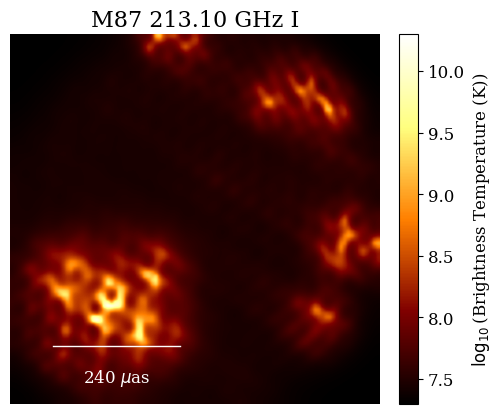

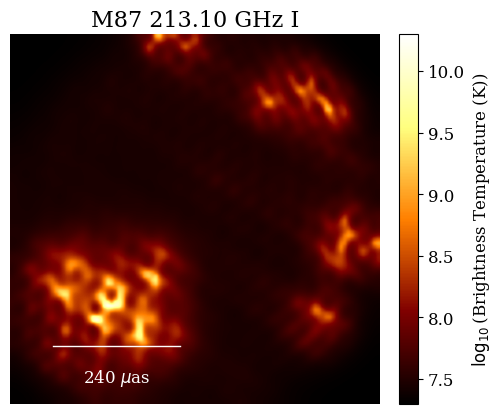

In [8]:
# Save the final image and self-calibrated data
imgr.out_last().save_fits('final_image.fits')
obs_sc.save_uvfits('selfcal_data.uvfits')

# Save a png of the final image
imgr.out_last().display(cbar_unit=['Tb'], label_type='scale', scale='log', export_pdf='final_image_logscale.png')

# Save summary of the final image and associated chi2
#eh.imgsum(imgr.out_last(), obs_sc, obs_init, 'imgsum.pdf')



Producing clean visibilities from image with direct FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Warning!: in add_noise, some SEFDs are <= 0!
NOT recomputing sigmas, which may result in double systematic noise


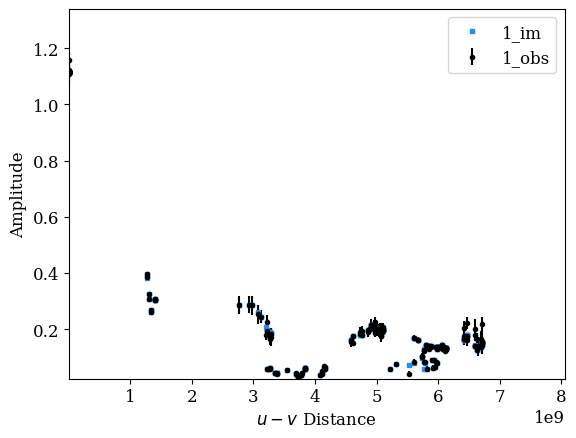

Producing clean visibilities from image with direct FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Warning!: in add_noise, some SEFDs are <= 0!
NOT recomputing sigmas, which may result in double systematic noise


/usr/local/lib/python3.10/dist-packages/ehtim/obsdata.py:2889: RuntimeWarning: divide by zero encountered in scalar divide
  if np.abs(bi) / bisig < snrcut:


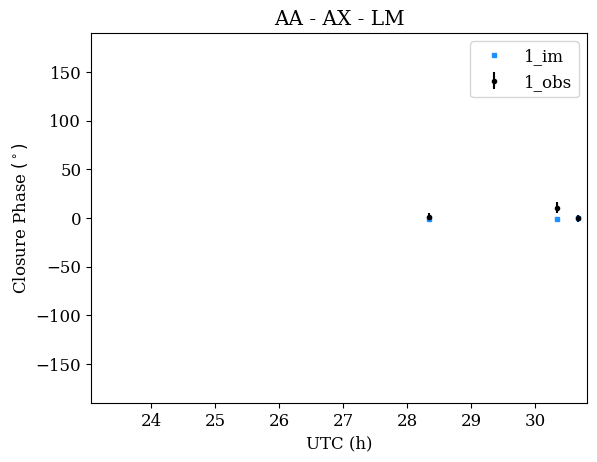

<Axes: title={'center': 'AA - AX - LM'}, xlabel='UTC (h)', ylabel='Closure Phase $(^\\circ)$'>

In [9]:
# Plot image model fit to visibility amplitudes
eh.plotall_obs_im_compare(obs_sc, imgr.out_last(), 'uvdist', 'amp', ttype='direct')

# Plot image model fit to closure phases
eh.plot_cphase_obs_im_compare(obs_sc, imgr.out_last(), 'AA', 'AX', 'LM', ttype='direct')



